# PHYS-GA2059 - Statistics and Data Science for Physicists
# Student: Gehan Ranepura
## Problem Set #6

In [78]:
import sys
import corner
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import pylab as pyplt
import random
import scipy as sci

from numpy.linalg import inv
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from numpy import random
from matplotlib import patches
from matplotlib.colors import LogNorm,Normalize
from pylab import gca, cm
from scipy import linalg
from scipy import stats
from scipy.linalg import *
from scipy.optimize import minimize
from scipy.stats import norm, invgamma, multivariate_normal

## Problem 1: 
Learn the hyperparameters of a Gaussian process kernel by Approximate Bayesian Computation. 
- You will need a GP implementation (your own, or you can use scikit-learn or tinygp or whatever) in which you can make draws from the prior over functions. 
- You will also need the small data set provided (on Discord) for this problem. 
- And you will need to choose some broad prior over the two parameters of the Matérn 3/2 kernel. 

Make your convex distance function on the data directly, so that a trial function gets a good (low) score if it matches all N data points nearly exactly. Obtain a good posterior sampling with a few hundred ABC-generated posterior samples.
- Bonus points: Compare the posterior sampling you get from ABC to the true posterior, which you can compute the old-school way.

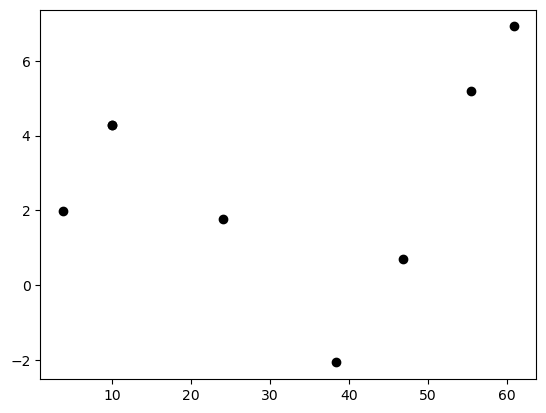

In [83]:
with open("data_ps6.pkl", "rb") as f:
    xs, ys = pkl.load(f)
    
plt.scatter(xs, ys, c = "k")

## Solution
The Matern 3/2 Kernel, https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

$$ 
\begin{align}
(\nu = 3/2): C_{3/2}(d) = \sigma^2 \left( 1 + \frac{\sqrt{3} d}{\rho} \right) 
                               \exp{\left( - \frac{\sqrt{3} d}{\rho} \right) }\
\end{align}
$$

In [84]:
# Define the Matern 3/2 kernel
def kernel_matern_3halves(sig, d, rho):
    return sig**2 * (1 + np.sqrt(3) * d/rho) * np.exp(-np.sqrt(3*d*d)/rho) 

## Problem 2: 
Re-do the regression of Problem Set 5, Problem 1, but now using a neural network. 

Either build your own, or else use a canned implementation from jax, pytorch, TensorFlow, or scikit-learn. 
- Compare your results to your Problem Set 5 results. 
- The deep learning results will be substantially better, right?

In [15]:
# Open up training and validation datasets from Jiadong's pickle files
with open("ap17_xpcont_train.pickle", 'rb') as d1:
    data_tr = pkl.load(d1)

with open("ap17_xpcont_validation.pickle", 'rb') as d2:
    data_val = pkl.load(d2)

# Both of these data sets contain keys for: BP coeff, RP coeff and 2 labels ( T_eff and log (g) )
 
print("Keys of training set and validation set:")
print(data_tr.keys(), "\n", data_val.keys(), "\n")

print("Dimensions of training set and validation set:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

# Instead of using the BP/RP coefficients right out of the box, 
# consider dividing all BP & RP coefficients by the first (zeroth) component of the RP coefficients. 

# TRAINING DATA:
max_RP_train = np.max(data_tr['rp_coef'])          # Find first component of the RP coeff
X_BP_train   = data_tr['bp_coef']/max_RP_train     # Divide BP and RP coeff by the first RP coeff component
X_RP_train   = data_tr['rp_coef']/max_RP_train
X_data_train = np.dstack((X_BP_train, X_RP_train)) # X_data_train has shape (4000, 55, 2) = BP and RP
Y_data_train = data_tr['labels'][:,0]              # Y_data_train has shape (4000, 1) = T_eff
print(X_data_train.shape, Y_data_train.shape)

# VALIDATION DATA:
max_RP_val = np.max(data_val['rp_coef'])           # Find first component of the RP coeff
X_BP_val   = data_val['bp_coef']/max_RP_val        # Divide BP and RP coeff by the first RP coeff component
X_RP_val   = data_val['rp_coef']/max_RP_val
X_data_val = np.dstack((X_BP_val, X_RP_val))       # X_data_val has shape (1000, 55, 2) = BP and RP
Y_data_val = data_val['labels'][:,0]               # Y_data_val has shape (1000,1) = T_eff
print(X_data_val.shape, Y_data_val.shape)

Keys of training set and validation set:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels']) 

Dimensions of training set and validation set:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]
(4000, 55, 2) (4000,)
(1000, 55, 2) (1000,)


In [85]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# The shape of X_data_train is the number of datapoints, with its 55 associated values for BP and RP
npoints, nx, ny = X_data_train.shape
print("X_data_train    : dimensions --> {} ".format(X_data_train.shape) )
print("Y_data_train    : dimensions --> {} ".format(Y_data_train.shape) )

# Reshape X_data_train such that, the array is now 2 dimensions (put togther BP and RP)
v2_X_data_train = X_data_train.reshape((npoints, nx*ny))
print("v2_X_data_train : dimensions --> {} ".format(v2_X_data_train.shape) )

X_data_train    : dimensions --> (4000, 55, 2) 
Y_data_train    : dimensions --> (4000,) 
v2_X_data_train : dimensions --> (4000, 110) 


In [86]:
# Using python neural network library sklearn, perform Multi-layer Perceptron regressor
# This model optimizes the squared error using LBFGS or stochastic gradient descent
# Fit the reshaped X_data_train and Y_data_train
regr = MLPRegressor(random_state=1, max_iter=1000).fit(v2_X_data_train, Y_data_train)

/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### At 1000 iterations, the MLPRegressor optimization still hasn't converged.
### This MLPRegressor takes too long to finish for 10,000 iterations but we can still use it for future calculations.

## Repeat Method for validation data

In [87]:
npoints, nx, ny = X_data_val.shape
print("X_data_val       : dimensions --> {} ".format(X_data_val.shape) )
print("Y_data_val       : dimensions --> {} ".format(Y_data_val.shape) )

v2_X_data_val = X_data_val.reshape(npoints, nx*ny)
print("v2_X_data_val    : dimensions --> {} ".format(v2_X_data_val.shape) )

# Perform regession prediction for validation data
regr.predict(v2_X_data_val)
regr.score(v2_X_data_val, Y_data_val)
print("Regression Score : dimensions --> {} ".format(regr.score(v2_X_data_val, Y_data_val)) )

X_data_val       : dimensions --> (1000, 55, 2) 
Y_data_val       : dimensions --> (1000,) 
v2_X_data_val    : dimensions --> (1000, 110) 
Regression Score : dimensions --> 0.23006541725494323 


## Plot Predictions vs validations

/var/folders/zn/wknmd3793w1b08wgws1qx64m0000gp/T/ipykernel_13551/487794088.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  SST  = np.sum((Y[i] - np.mean(Y_hat))**2 for i in range(len(Y))) # total sum of squares


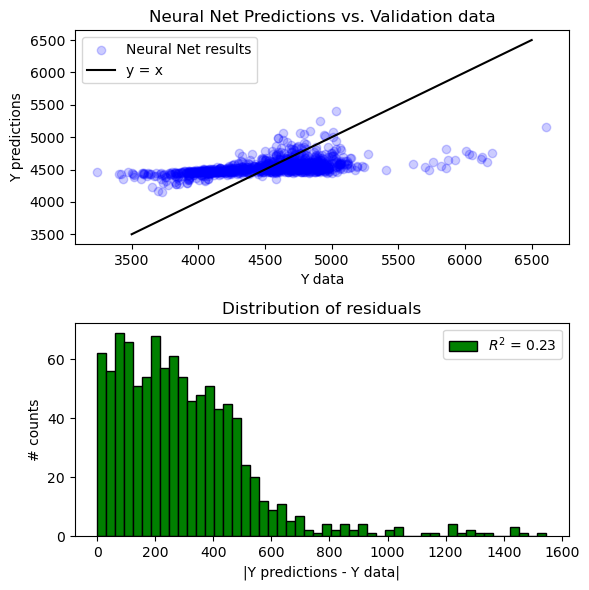

In [89]:
fig, [ax0, ax1] = plt.subplots(2, figsize = (6, 6))
Y               = Y_data_val.flatten()                  # Y Validation data
Y_hat           = regr.predict(v2_X_data_val)           # Neural Net Predictions using X Validation Data

ax0.scatter(Y, Y_hat, marker = 'o', c = 'blue', alpha = 0.2, label = 'Neural Net results')
ax0.plot([3500, 6500], [3500, 6500], 'k-', label = 'y = x')
ax0.set_title('Neural Net Predictions vs. Validation data')
ax0.legend()
ax0.set_xlabel(r'Y data')
ax0.set_ylabel(r'Y predictions')

# Compare to Problem Set 5 results
res  = abs(Y-Y_hat) 
SSR  = np.sum(res**2)                                            # sum of squares of residuals
SST  = np.sum((Y[i] - np.mean(Y_hat))**2 for i in range(len(Y))) # total sum of squares
R_sq = 1-SSR/SST

ax1.hist(res, bins = 50, color = "green", ec="black", label='$R^2$ = {}'.format(np.round(R_sq,2)))
ax1.set_title('Distribution of residuals')
ax1.legend()
ax1.set_ylabel('# counts')
ax1.set_xlabel('|Y predictions - Y data|')
plt.tight_layout()

### The neural network performed quite poorly compared to the Linear Regression Model we used in PS5-1